# Customer Segmentation

The goal of this project is to identify distinct groups of customers based on their purchasing behavior. In real-world use, this is used to target marketing efforts, personalize customer experiences, and allocate resources more efficiently.

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

from datetime import datetime


In [2]:
df = pd.read_excel("./data/Customers.xlsx")

df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


#### Data Cleaning and Feature Engineering

In [3]:
df = df[df["Quantity"] > 0]
df = df[df["UnitPrice"] > 0]
df = df.dropna(subset=["CustomerID"])

df["TotalPrice"] = df["Quantity"] * df["UnitPrice"]

df.shape, df.isna().sum()

((397884, 9),
 InvoiceNo      0
 StockCode      0
 Description    0
 Quantity       0
 InvoiceDate    0
 UnitPrice      0
 CustomerID     0
 Country        0
 TotalPrice     0
 dtype: int64)

Extracting features "Recency", "Frequency", and "Monetary"

- Recency is the amount of days since last purchase

- Frequency is the total number of purchases

- Monetry is the total revenue

In [4]:
snapshot_date = df["InvoiceDate"].max() + pd.Timedelta(days=1)

rfm = df.groupby("CustomerID").agg({
    "InvoiceDate": lambda x: (snapshot_date - x.max()).days,
    "InvoiceNo": "nunique",
    "TotalPrice": "sum"
})

rfm.columns = ["Recency", "Frequency", "Monetary"]
rfm.head()

,Recency,Frequency,Monetary
CustomerID,,,
12346.0,326,1,77183.60
12347.0,2,7,4310.00
12348.0,75,4,1797.24
12349.0,19,1,1757.55
12350.0,310,1,334.40


Correcting skewness and standardizing the data

In [5]:
features = rfm.copy()

# Log transform to reduce skewness
print(features.skew())
features = np.log1p(features)
print(features.skew())

# Standardize
scaler = StandardScaler()
X_scaled = scaler.fit_transform(features)

Recency       1.246048
Frequency    12.067031
Monetary     19.324953
dtype: float64
Recency     -0.379169
Frequency    1.208652
Monetary     0.393553
dtype: float64


### Deciding the number of clusters

#### Elbow method

Seeing if there is an obvious drop ("elbow") in the sum of squared errors at any n

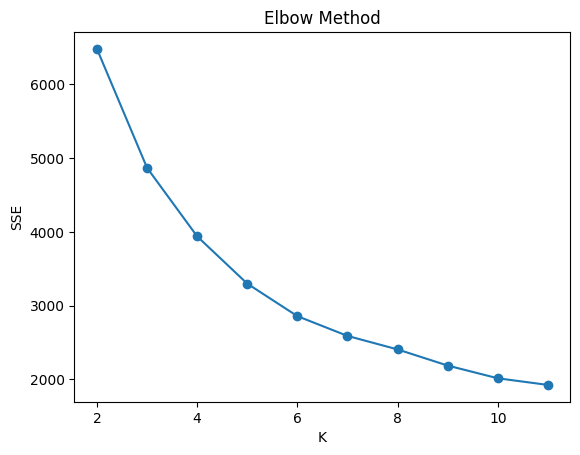

In [6]:
sse = []
K = range(2, 12)

for k in K:
    model = KMeans(n_clusters=k, random_state=42)
    model.fit(X_scaled)
    sse.append(model.inertia_)

plt.plot(K, sse, marker="o")
plt.xlabel("K")
plt.ylabel("SSE")
plt.title("Elbow Method")
plt.show()

The curve looks smooth so there is no elbow

#### Silouette Score

Seeing the clustering with the highest silhouette score. This estimates how good the clustering is.

In [7]:
for k in range(2, 8):
    model = KMeans(n_clusters=k, random_state=42)
    labels = model.fit_predict(X_scaled)
    score = silhouette_score(X_scaled, labels)
    print(f"K={k}, silhouette={score:.3f}")


K=2, silhouette=0.433
K=3, silhouette=0.336
K=4, silhouette=0.337
K=5, silhouette=0.317
K=6, silhouette=0.314
K=7, silhouette=0.287


Two clusters seems to be the best number

Adding cluster assignments to the rfm

In [8]:
k = 2
model = KMeans(n_clusters=k, random_state=42)
rfm["Cluster"] = model.fit_predict(X_scaled)

rfm.head()


,Recency,Frequency,Monetary,Cluster
CustomerID,,,,
12346.0,326,1,77183.60,1
12347.0,2,7,4310.00,1
12348.0,75,4,1797.24,1
12349.0,19,1,1757.55,0
12350.0,310,1,334.40,0


Grouping by cluster:

In [9]:
cluster_summary = rfm.groupby("Cluster").mean().round(2)
cluster_summary

,Recency,Frequency,Monetary
Cluster,,,
0,133.89,1.68,499.77
1,25.70,8.47,4566.96


Visualizing:

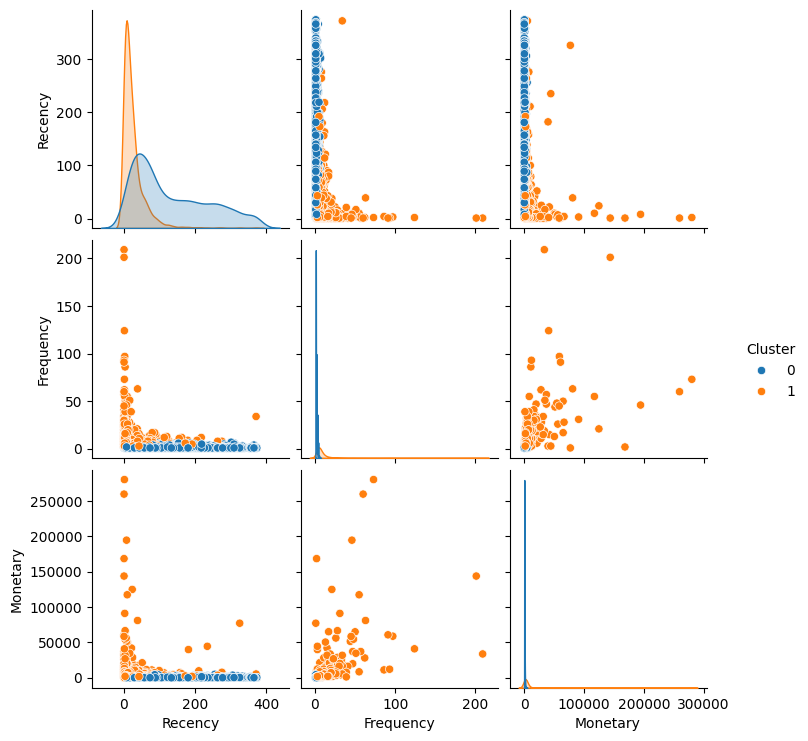

In [10]:
sns.pairplot(rfm.reset_index(), hue="Cluster", vars=["Recency","Frequency","Monetary"])
plt.show()


Here we can see two distinct clusters:

Cluster 0: Has purchases with low frequency and makes little monetary contribution.

Cluster 1: Has on average lower recency. High frequency and monetary contribution.

## Recap

In this project, I performed customer segmentation to identify distinct groups based on behavioral and demographic features. The process involved data preprocessing, and feature scaling, followed by applying clustering. I evaluated different clustering approaches to determine an appropriate number of segments and interpreted each segment’s characteristics. The final result provided clear, actionable customer groups that can be used to inform targeted marketing and business strategies.